<a href="https://colab.research.google.com/github/a-donat/InProgress/blob/main/Predict_LTV_Ratio_Customers_w_Two_Policies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Load Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ranja7/vehicle-insurance-customer-data
! unzip '/content/vehicle-insurance-customer-data.zip' -d '/content/data'

In [ ]:
! pip install mlinsights
! unzip '/content/Relationships' -d '/content/'

In [ ]:
! pip install pycaret

In [ ]:
! pip uninstall scipy -y
! pip install scipy
! pip uninstall yellowbrick -y
! pip install yellowbrick

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import sys
import importlib
from typing import *
from sklearn.model_selection import train_test_split

In [6]:
from pycaret.regression import *

# II. Data Preprocessing

In [19]:
ltv_df = pd.read_csv("/content/data/AutoInsurance.csv")

In [20]:
ltv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [21]:
ltv_df["ltv_mpa_ratio"] = (
  ltv_df["Customer Lifetime Value"] - 600)/(
      ltv_df["Monthly Premium Auto"])

In [22]:
ltv_df["Effective To Date"] = pd.to_datetime(ltv_df["Effective To Date"])
ltv_df["Effective To Date"] = (
    ltv_df["Effective To Date"] - ltv_df["Effective To Date"].min()).dt.days
ltv_df["Policy Level"] = ltv_df["Policy"].str.split("\s+", expand=True)[1]

In [23]:
ltv_df["vehicle class group"] = ltv_df["Vehicle Class"].map({
    "Two-Door Car": "A", "Sports Car": "B", "Four-Door Car": "A", "SUV": "B",
    "Luxury SUV": "C", "Luxury Car": "C"})

In [24]:
ltv_train, ltv_test = train_test_split(ltv_df, test_size=.15, random_state=1)

In [25]:
del ltv_df

In [26]:
ltv_train = ltv_train[ltv_train["Number of Policies"] == 2].copy()
ltv_test = ltv_test[ltv_test["Number of Policies"] == 2].copy()


In [14]:
print(ltv_train.shape)
print(ltv_test.shape)

(1948, 26)
(346, 26)


# III. Machine Learning Models

In [27]:
ltv_models = setup(
    data=ltv_train, target = "ltv_mpa_ratio",
    ignore_features=[
        "Customer", "Number of Policies", "Customer Lifetime Value"],
    session_id=123)


,Description,Value
0,Session id,123
1,Target,ltv_mpa_ratio
2,Target type,Regression
3,Original data shape,"(1948, 27)"
4,Transformed data shape,"(1948, 69)"
5,Transformed train set shape,"(1363, 69)"
6,Transformed test set shape,"(585, 69)"
7,Ignore features,3
8,Ordinal features,2
9,Numeric features,7


In [28]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,63.5877,5967.3754,77.1504,0.0237,0.4292,0.4175,1.8420
br,Bayesian Ridge,67.2295,6201.2535,78.6300,-0.0115,0.4331,0.4316,0.3020
dummy,Dummy Regressor,66.9745,6207.1166,78.6549,-0.0117,0.4336,0.4307,0.3620
en,Elastic Net,67.1752,6226.1279,78.7789,-0.0151,0.4338,0.4307,0.3000
gbr,Gradient Boosting Regressor,64.4797,6199.7353,78.6638,-0.0152,0.4331,0.4119,0.8320
omp,Orthogonal Matching Pursuit,67.2523,6228.5624,78.7972,-0.0156,0.4339,0.4313,0.3700
lasso,Lasso Regression,67.1174,6241.6251,78.8795,-0.0179,0.4345,0.4304,0.3020
llar,Lasso Least Angle Regression,67.1174,6241.6250,78.8795,-0.0179,0.4345,0.4304,0.5180
ridge,Ridge Regression,67.2250,6463.8378,80.2757,-0.0544,0.4434,0.4301,0.3060
lr,Linear Regression,67.2360,6470.9678,80.3203,-0.0556,0.4437,0.4301,1.8640


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [30]:
rf = create_model("rf", fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63.4391,6212.3294,78.8183,0.0844,0.4215,0.3903
1,66.3250,6599.4873,81.2372,0.0583,0.4409,0.4251
2,60.3111,5340.5412,73.0790,0.0895,0.4115,0.3982
3,66.0206,6511.3647,80.6930,-0.0515,0.4446,0.4259
4,61.8430,5173.1545,71.9246,-0.0622,0.4273,0.4478
Mean,63.5877,5967.3754,77.1504,0.0237,0.4292,0.4175
Std,2.3330,596.5233,3.8966,0.0667,0.0123,0.0208


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

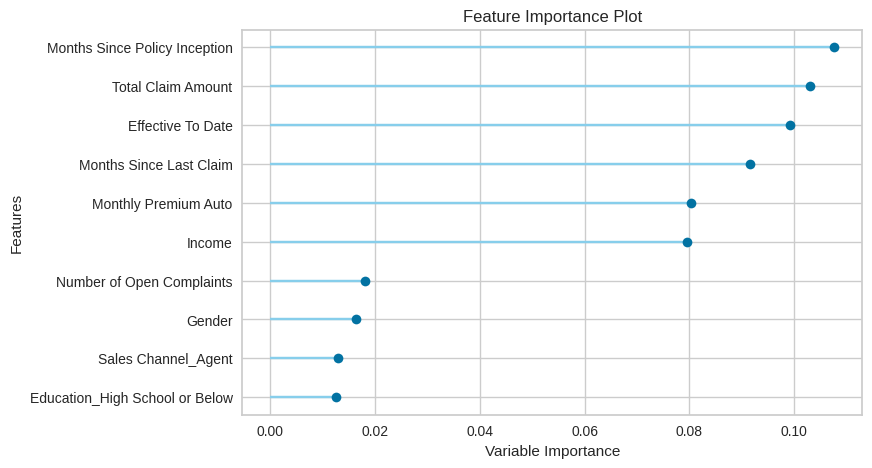

In [31]:
plot_model(rf, plot="feature")

In [35]:
tuned_rf = tune_model(rf, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,66.6279,6420.7645,80.1297,0.0536,0.4260,0.4041
1,67.1911,6610.2414,81.3034,0.0568,0.4331,0.4159
2,62.3640,5459.3356,73.8873,0.0693,0.4099,0.4014
3,65.2385,6159.5669,78.4829,0.0053,0.4270,0.4122
4,62.0309,4904.3313,70.0309,-0.0070,0.4150,0.4403
Mean,64.6905,5910.8479,76.7668,0.0356,0.4222,0.4148
Std,2.1351,636.8620,4.2071,0.0305,0.0085,0.0138


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [41]:
trf_holdout_preds = predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,65.1647,5926.3249,76.9826,0.0900,0.4187,0.4076


In [37]:
trf_train_preds = predict_model(tuned_rf, data=ltv_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,56.0929,4474.2750,66.8900,0.2885,0.3664,0.3576


In [40]:
trf_test_preds = predict_model(tuned_rf, data=ltv_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,62.9324,5564.0588,74.5926,0.0537,0.4193,0.4199


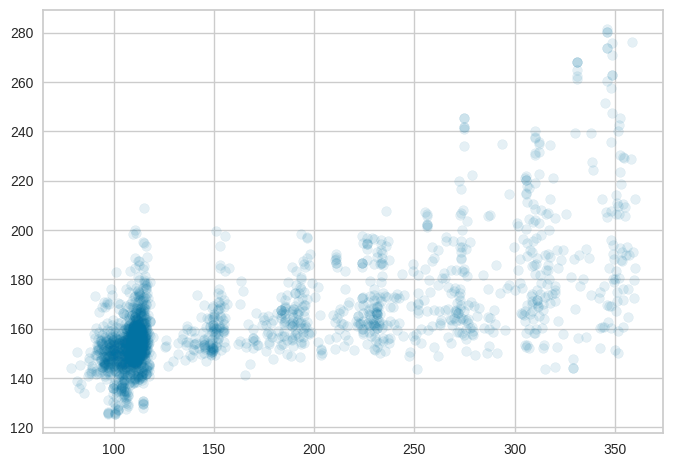

In [39]:
plt.scatter(
    trf_train_preds["ltv_mpa_ratio"], trf_train_preds["prediction_label"],
    alpha=.1)

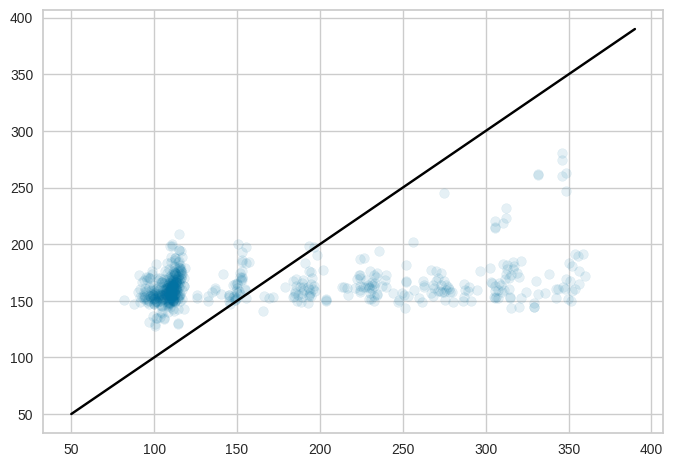

In [43]:
plt.scatter(
    trf_holdout_preds["ltv_mpa_ratio"], trf_holdout_preds["prediction_label"],
    alpha=.1)
plt.plot(np.arange(50, 400, 10), np.arange(50, 400, 10), color="black")

In [50]:
(trf_holdout_preds["ltv_mpa_ratio"] - trf_holdout_preds["prediction_label"]
 ).describe(percentiles=[.25, .6, .64, .75, .9]).round(0)

count    585.0
mean       3.0
std       77.0
min      -94.0
25%      -53.0
50%      -40.0
60%      -16.0
64%       -2.0
75%       61.0
90%      134.0
max      202.0
dtype: float64

In [56]:
list(trf_train_preds)

['Customer',
 'State',
 'Customer Lifetime Value',
 'Response',
 'Coverage',
 'Education',
 'Effective To Date',
 'EmploymentStatus',
 'Gender',
 'Income',
 'Location Code',
 'Marital Status',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Total Claim Amount',
 'Vehicle Class',
 'Vehicle Size',
 'Policy Level',
 'vehicle class group',
 'ltv_mpa_ratio',
 'prediction_label']

In [52]:
trf_holdout_preds["pred_ltv"] = (
    trf_holdout_preds["prediction_label"]
    * trf_holdout_preds["Monthly Premium Auto"]) + 600

In [57]:
trf_train_preds["pred_ltv"] = (
    trf_train_preds["prediction_label"]
    * trf_train_preds["Monthly Premium Auto"]) + 600

In [58]:
trf_train_preds[["pred_ltv", "Customer Lifetime Value"]].corr()

,pred_ltv,Customer Lifetime Value
pred_ltv,1.000000,0.735205
Customer Lifetime Value,0.735205,1.000000


In [61]:
(trf_train_preds["Customer Lifetime Value"] - trf_train_preds["pred_ltv"]).describe().round(0)

count     1948.0
mean        55.0
std       6503.0
min     -15076.0
25%      -3949.0
50%      -2899.0
75%       4151.0
max      36351.0
dtype: float64

In [59]:
trf_test_preds["pred_ltv"] = (
    trf_test_preds["prediction_label"]
    * trf_test_preds["Monthly Premium Auto"]) + 600

In [60]:
trf_test_preds[["pred_ltv", "Customer Lifetime Value"]].corr()

,pred_ltv,Customer Lifetime Value
pred_ltv,1.000000,0.545169
Customer Lifetime Value,0.545169,1.000000
